## Imports

In [5]:
import os, re, math, random
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tvio
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict


## Utils

In [ ]:
def set_seed(s=123):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

torch.backends.cudnn.benchmark = True
set_seed(42)

try:
    font = ImageFont.load_default()
except:
    font = None

def kernel_to_u8_img(kernel_2d: torch.Tensor) -> Image.Image:
    arr = kernel_2d.numpy()
    mn, mx = arr.min(), arr.max()
    if mx - mn < 1e-12:
        norm = np.zeros_like(arr, dtype=np.float32)
    else:
        norm = (arr - mn) / (mx - mn)
    u8 = (norm * 255.0 + 0.5).astype(np.uint8)
    img = Image.fromarray(u8, mode="L")
    return img.resize((tile_w, tile_h), resample=Image.NEAREST)



def psnr(x: torch.Tensor, y: torch.Tensor, eps=1e-8) -> float:
    mse = F.mse_loss(x, y).item()
    if mse <= eps: return 99.0
    return 10.0 * math.log10(1.0 / mse)

device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu")
)

def check_sample(x):
    if isinstance(x, torch.Tensor):
        return True
    try:
        _ = torch.as_tensor(x)
        return True
    except Exception:
        return False

rng = np.random.default_rng()

def rand_color():
    return tuple(int(x) for x in rng.integers(0, 256, size=3))

def _rgb_to_bgr(c):
    return (int(c[2]), int(c[1]), int(c[0]))

def random_point(W, H):
    return (int(rng.integers(0, W)),
            int(rng.integers(0, H)))

def gen_polygon_points(n, W, H):
    pts = np.array([random_point(W, H) for _ in range(n)], dtype=np.int32)
    cx, cy = pts[:,0].mean(), pts[:,1].mean()
    ang = np.arctan2(pts[:,1] - cy, pts[:,0] - cx)
    order = np.argsort(ang)
    return pts[order]

def draw_triangle(img_np, color):
    H, W = img_np.shape[:2]
    pts = gen_polygon_points(3, W, H).reshape(-1, 1, 2)
    cv2.fillPoly(img_np, [pts], _rgb_to_bgr(color), lineType=cv2.LINE_AA)

def draw_quadrilateral(img_np, color):
    H, W = img_np.shape[:2]
    pts = gen_polygon_points(4, W, H).reshape(-1, 1, 2)
    cv2.fillPoly(img_np, [pts], _rgb_to_bgr(color), lineType=cv2.LINE_AA)

def draw_ellipse(img_np, color):
    H, W = img_np.shape[:2]
    cx, cy = random_point(W, H)
    rx = int(rng.integers(3, W/2))
    ry = int(rng.integers(3, H/2))
    angle = float(rng.uniform(0, 180))
    cv2.ellipse(
        img_np,
        (cx, cy), (rx, ry),
        angle, 0, 360,
        _rgb_to_bgr(color),
        thickness=-1,
        lineType=cv2.LINE_AA
    )

def draw_star(img_np, color):
    H, W = img_np.shape[:2]
    cx, cy = random_point(W, H)
    bgr = _rgb_to_bgr(color)
    for _ in range(5):
        x2, y2 = random_point(W, H)
        cv2.line(img_np, (cx, cy), (x2, y2), bgr, thickness=1, lineType=cv2.LINE_AA)

def generate_clean_image(size=256, per_shape=5):
    img = np.zeros((size, size, 3), dtype=np.uint8)
    img[:] = rand_color()
    for _ in range(per_shape):
        draw_triangle(img, rand_color())
        draw_quadrilateral(img, rand_color())
        draw_ellipse(img, rand_color())
        draw_star(img, rand_color())
    return img

def to_float01(img_u8): 
    return img_u8.astype(np.float32) / 255.0

def to_uint8(img_f):
    return (np.clip(img_f, 0.0, 1.0) * 255.0 + 0.5).astype(np.uint8)

def add_additive_noise(img_u8):
    x = to_float01(img_u8)
    sigma = float(rng.uniform(0.1, 0.3))
    n = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    y = x + n
    return to_uint8(y), sigma

def add_multiplicative_noise(img_u8):
    x = to_float01(img_u8)
    sigma = float(rng.uniform(0.1, 0.3))
    n = rng.normal(1.0, sigma, size=x.shape).astype(np.float32)
    y = x * n
    return to_uint8(y), sigma

def snr(x: torch.Tensor, y: torch.Tensor, eps=1e-8) -> float:
    signal_power = torch.mean(y**2).item()
    noise_power = torch.mean((x - y)**2).item()
    if noise_power <= eps:
        return 99.0
    return 10.0 * math.log10(signal_power / noise_power)
    
def chunk_avg(values, chunk_size=200):
    n = len(values)
    n_chunks = n // chunk_size
    return [np.mean(values[i*chunk_size:(i+1)*chunk_size]) for i in range(n_chunks)]

def generate_sample_tensor(size=256, device=device):
    clean_u8 = generate_clean_image(size=size, per_shape=5)

    x = to_float01(clean_u8)
    sigma = float(rng.uniform(0.0, 0.3))

    if rng.random() < 0.5:
        noise_type = "additive"
        n = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
        noisy_u8 = to_uint8(x + n)
    else:
        noise_type = "multiplicative"
        n = rng.normal(1.0, sigma, size=x.shape).astype(np.float32)
        noisy_u8 = to_uint8(x * n)

    clean = torch.from_numpy(clean_u8).permute(2, 0, 1).float() / 255.0
    noisy = torch.from_numpy(noisy_u8).permute(2, 0, 1).float() / 255.0

    clean = clean.unsqueeze(0).to(device)
    noisy = noisy.unsqueeze(0).to(device)

    noisy = torch.clamp(noisy, 0.0, 1.0)

    meta = {
        "type": noise_type,
        "sigma": sigma,
        "size": size,
    }
    return noisy, clean, meta

## Model Architecture

In [ ]:
class BranchA_Shared(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_shared = nn.Conv2d(1, 8, kernel_size=11, padding=5, bias=True)
        nn.init.kaiming_normal_(self.conv_shared.weight, nonlinearity='linear')
        nn.init.zeros_(self.conv_shared.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        x_flat = x.view(B * C, 1, H, W)
        y = self.conv_shared(x_flat)
        return y.view(B, C * 8, H, W)

class ResBlock(nn.Module):
    def __init__(self, in_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        self.use_proj = (in_ch != 32)
        self.conv1 = nn.Conv2d(in_ch, 32, 3, padding=1, bias=not use_bn)
        self.bn1   = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, bias=not use_bn)
        self.bn2   = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.relu  = nn.ReLU(inplace=True)
        self.drop  = nn.Dropout2d(p_drop) if p_drop > 0 else nn.Identity()
        self.proj  = nn.Conv2d(in_ch, 32, 1) if self.use_proj else nn.Identity()
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out); out = self.drop(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.use_proj: identity = self.proj(identity)
        return self.relu(out + identity)

class BranchB_Weights(nn.Module):
    def __init__(self, use_bn=True, p_drop=0.0):
        super().__init__()
        self.block1 = ResBlock(3,  use_bn=use_bn, p_drop=p_drop)
        self.block2 = ResBlock(32, use_bn=use_bn, p_drop=p_drop)
        self.block3 = ResBlock(32, use_bn=use_bn, p_drop=p_drop)
        self.to8    = nn.Conv2d(32, 8, kernel_size=1)
        nn.init.kaiming_normal_(self.to8.weight, nonlinearity='linear')
        nn.init.zeros_(self.to8.bias)
    def forward(self, x):
        out = self.block1(x); out = self.block2(out); out = self.block3(out)
        logits = self.to8(out)
        return F.softmax(logits, dim=1)

class EdgePreservingDenoiser(nn.Module):
    def __init__(self, use_bn=True, p_drop=0.0):
        super().__init__()
        self.branchA = BranchA_Shared()
        self.branchB = BranchB_Weights(use_bn=use_bn, p_drop=p_drop)
    def forward(self, x)
        A = self.branchA(x)
        W = self.branchB(x)
        A_R = A[:, 0:8,   :, :]
        A_G = A[:, 8:16,  :, :]
        A_B = A[:, 16:24, :, :]
        R = (A_R * W).sum(1, keepdim=True)
        G = (A_G * W).sum(1, keepdim=True)
        B = (A_B * W).sum(1, keepdim=True)
        return torch.cat([R, G, B], dim=1)

## Build Model

In [14]:
model = EdgePreservingDenoiser(use_bn=True, p_drop=0.0).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
print(repr(model))

EdgePreservingDenoiser(
  (branchA): BranchA_Shared(
    (conv_shared): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  )
  (branchB): BranchB_Weights(
    (block1): ResBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (drop): Identity()
      (proj): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (block2): ResBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

## Training

Training (on-the-fly, 1 sample per epoch)...


Epochs: 100%|██████████| 30000/30000 [1:50:16<00:00,  4.53it/s, loss=0.0009, psnr=30.55 dB, noise=additive, sigma=0.16, gstep=3e+4]            


Saved → edge_denoiser.pth


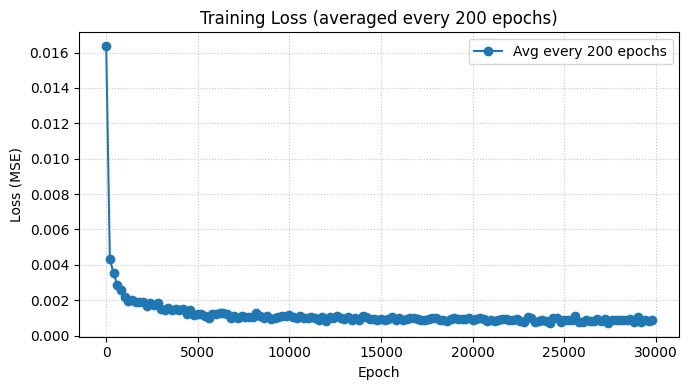

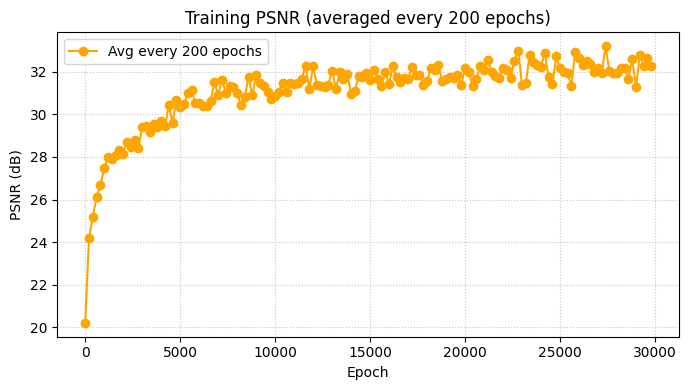

In [10]:

def train_epochs_on_the_fly(
    model, opt, loss_fn, device,
    epochs=2, save_path="edge_denoiser.pth", img_size=256
):
    print("Training (on-the-fly, 1 sample per epoch)...")
    model.train()
    gstep = 0

    loss_hist = []
    psnr_hist = []

    pbar = tqdm(range(1, epochs + 1), dynamic_ncols=True, desc="Epochs")
    for ep in pbar:
        noisy, clean, meta = generate_sample_tensor(size=img_size, device=device)

        pred = model(noisy)
        loss = loss_fn(pred, clean)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        gstep += 1

        with torch.no_grad():
            cur_psnr = psnr(pred[0], clean[0])

        loss_hist.append(float(loss.item()))
        psnr_hist.append(float(cur_psnr))

        postfix = {
            "loss": f"{loss.item():.4f}",
            "psnr": f"{cur_psnr:.2f} dB",
            "noise": f"{meta['type']}",
            "sigma": f"{meta['sigma']:.2f}",
            "gstep": gstep
        }
        pbar.set_postfix(postfix)

        torch.save(model.state_dict(), save_path)

    print(f"Saved → {save_path}")
    return {"loss": loss_hist, "psnr": psnr_hist}


hist = train_epochs_on_the_fly(
    model, opt, loss_fn, device,
    epochs=30000, save_path="edge_denoiser.pth", img_size=256
)

chunk_size = 200
loss_avg = chunk_avg(hist["loss"], chunk_size)
psnr_avg = chunk_avg(hist["psnr"], chunk_size)
x = np.arange(len(loss_avg)) * chunk_size

plt.figure(figsize=(7, 4))
plt.plot(x, loss_avg, marker="o", label=f"Avg every {chunk_size} epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss (averaged every 200 epochs)")
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(x, psnr_avg, marker="o", color="orange", label=f"Avg every {chunk_size} epochs")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Training PSNR (averaged every 200 epochs)")
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


## Results

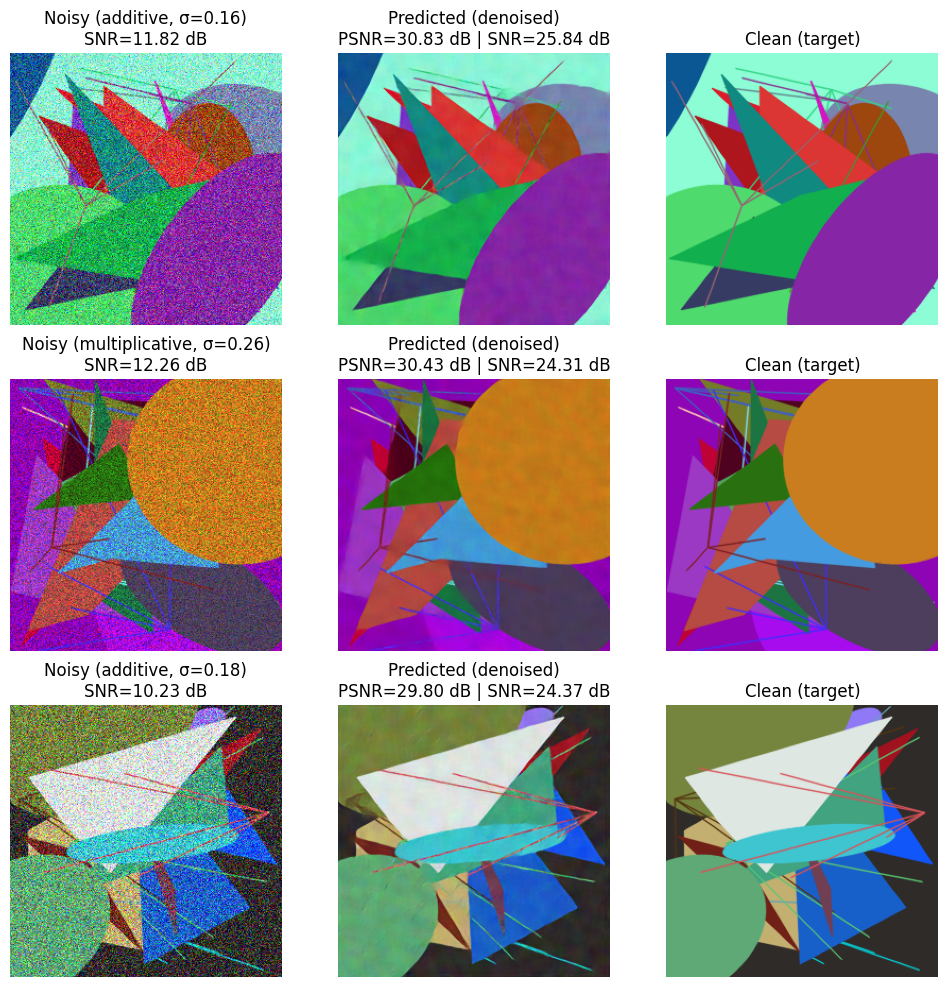

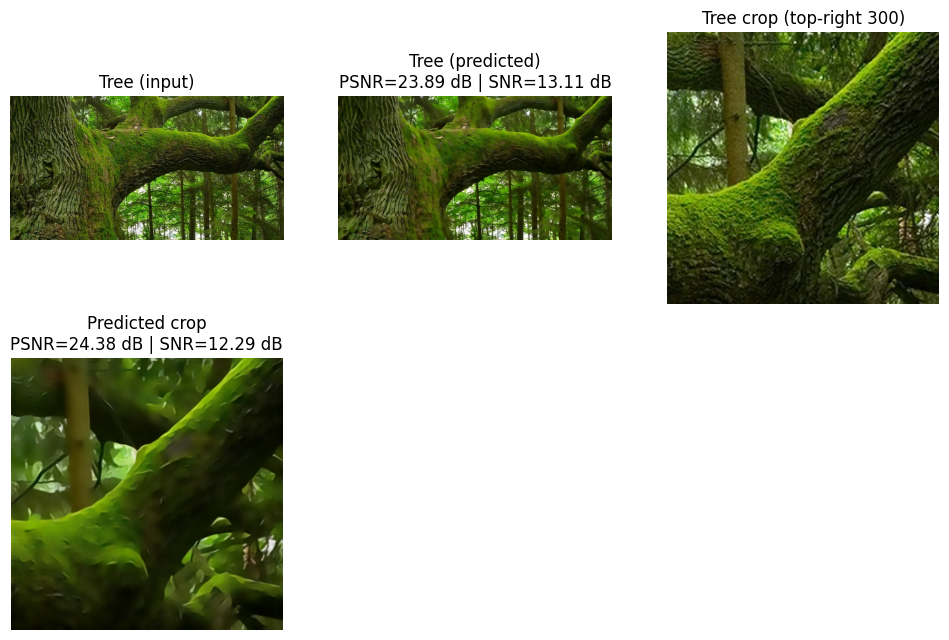

In [ ]:
import torchvision.transforms.functional as TF

tree_path = "test-tree/test-tree.jpg"
crop_size = 300
pred_results = []

model = EdgePreservingDenoiser(use_bn=True, p_drop=0.0)
model.load_state_dict(torch.load("edge_denoiser.pth", map_location=device))
model.to(device)
model.eval()

@torch.no_grad()
def to_np_img(t: torch.Tensor):
    arr = t.detach().float().cpu().permute(1, 2, 0).numpy()
    return np.clip(arr, 0.0, 1.0)

@torch.no_grad()
def run_once(x_chw: torch.Tensor):
    pred = model(x_chw.unsqueeze(0).to(device)).clamp_(0.0, 1.0)[0]
    return pred

with torch.no_grad():
    for i in range(5):
        noisy, clean, meta = generate_sample_tensor(size=256, device=device)
        pred = model(noisy).clamp_(0.0, 1.0)

        psnr_pred = psnr(pred[0], clean[0])
        snr_noisy = snr(noisy[0], clean[0])
        snr_pred  = snr(pred[0],  clean[0])

        noisy_np = to_np_img(noisy[0])
        pred_np  = to_np_img(pred[0])
        clean_np = to_np_img(clean[0])
        pred_results.append({
            "noisy": noisy_np,
            "pred": pred_np,
            "clean": clean_np,
            "psnr": psnr_pred,
            "snr_noisy": snr_noisy,
            "snr_pred": snr_pred,
            "meta": meta
        })
tree_img = Image.open(tree_path).convert("RGB")
tree_tensor = TF.pil_to_tensor(tree_img).float() / 255.0 

pred_tree = run_once(tree_tensor)

psnr_tree_pred = psnr(pred_tree, tree_tensor.to(device))
snr_tree_pred  = snr(pred_tree, tree_tensor.to(device))

tree_np      = to_np_img(tree_tensor)
pred_tree_np = to_np_img(pred_tree)

C, H, W = tree_tensor.shape
x0 = max(0, W - crop_size)
y0 = 0
tree_crop = tree_tensor[:, y0:y0+crop_size, x0:x0+crop_size]
pred_crop = run_once(tree_crop)

psnr_crop_pred = psnr(pred_crop, tree_crop.to(device))
snr_crop_pred  = snr(pred_crop, tree_crop.to(device))

tree_crop_np     = to_np_img(tree_crop)
pred_crop_np     = to_np_img(pred_crop)

plt.figure(figsize=(12, 12))


for i in range(3):  
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(pred_results[i]["noisy"]); plt.axis("off")
    plt.title(f"Noisy ({pred_results[i]['meta']['type']}, σ={pred_results[i]['meta']['sigma']:.2f})\nSNR={pred_results[i]['snr_noisy']:.2f} dB")
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(pred_results[i]["pred"]); plt.axis("off")
    plt.title(f"Predicted (denoised)\nPSNR={pred_results[i]['psnr']:.2f} dB | SNR={pred_results[i]['snr_pred']:.2f} dB")
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(pred_results[i]["clean"]); plt.axis("off")
    plt.title("Clean (target)")

# plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.imshow(tree_np); plt.axis("off")
plt.title("Tree (input)")
plt.subplot(3, 3, 2)
plt.imshow(pred_tree_np); plt.axis("off")
plt.title(f"Tree (predicted)\nPSNR={psnr_tree_pred:.2f} dB | SNR={snr_tree_pred:.2f} dB")


plt.subplot(3, 3, 3)
plt.imshow(tree_crop_np); plt.axis("off")
plt.title("Tree crop (top-right " + str(crop_size) + ")")
plt.subplot(3, 3, 4)
plt.imshow(pred_crop_np); plt.axis("off")
plt.title(f"Predicted crop\nPSNR={psnr_crop_pred:.2f} dB | SNR={snr_crop_pred:.2f} dB")


# plt.tight_layout()
plt.show()

## Kernels

BranchA_Shared kernels (11×11), per-kernel normalized, grayscale. Indices 0–7 are shared across R,G,B.


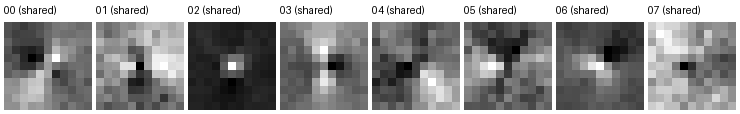

In [101]:
with torch.no_grad():
    W = model.branchA.conv_shared.weight.detach().cpu()

num_k = W.shape[0]
kH, kW = W.shape[-2], W.shape[-1]
cols = 8
rows = (num_k + cols - 1) // cols

scale = 8
pad = 4
label_h = 18
tile_w, tile_h = kW*scale, kH*scale
grid_w = cols*tile_w + (cols+1)*pad
grid_h = rows*(tile_h + label_h) + (rows+1)*pad

canvas = Image.new("L", (grid_w, grid_h), color=255)
draw = ImageDraw.Draw(canvas)

for k in range(num_k):
    r = k // cols
    c = k % cols
    x0 = pad + c*(tile_w + pad)
    y0 = pad + r*(tile_h + label_h + pad)

    ker_img = kernel_to_u8_img(W[k, 0, :, :])
    label = f"{k:02d} (shared)"
    draw.text((x0, y0), label, fill=0, font=font)
    canvas.paste(ker_img, (x0, y0 + label_h))

print("BranchA_Shared kernels (11×11), per-kernel normalized, grayscale. Indices 0–7 are shared across R,G,B.")
display(canvas)


## Evaluation

In [25]:
model.eval()

N_SAMPLES = 1000
rng_seed = 42

@torch.inference_mode()
def evaluate_model(n_samples=N_SAMPLES, size=256, device=device, show_progress=True):
    if rng_seed is not None:
        torch.manual_seed(rng_seed)
        try:
            import random; random.seed(rng_seed)
            np.random.seed(rng_seed)
        except Exception:
            pass

    psnr_pred_vals = []
    snr_noisy_vals = []
    snr_pred_vals  = []

    iterator = range(n_samples)
    try:
        from tqdm import tqdm
        if show_progress:
            iterator = tqdm(iterator, desc="Evaluating", unit="img")
    except Exception:
        pass

    for _ in iterator:
        noisy, clean, meta = generate_sample_tensor(size=size, device=device)
        pred = model(noisy).clamp_(0.0, 1.0)

        B = noisy.shape[0]
        for b in range(B):
            psnr_val = psnr(pred[b], clean[b])
            snr_noisy_val = snr(noisy[b], clean[b])
            snr_pred_val  = snr(pred[b],  clean[b])

            psnr_pred_vals.append(float(psnr_val))
            snr_noisy_vals.append(float(snr_noisy_val))
            snr_pred_vals.append(float(snr_pred_val))

    psnr_pred_vals = np.array(psnr_pred_vals, dtype=np.float64)
    snr_noisy_vals = np.array(snr_noisy_vals, dtype=np.float64)
    snr_pred_vals  = np.array(snr_pred_vals,  dtype=np.float64)

    results = {
        "count": len(psnr_pred_vals),
        "PSNR_pred_mean": float(psnr_pred_vals.mean()),
        "PSNR_pred_std":  float(psnr_pred_vals.std(ddof=1)) if len(psnr_pred_vals) > 1 else 0.0,
        "SNR_noisy_mean": float(snr_noisy_vals.mean()),
        "SNR_noisy_std":  float(snr_noisy_vals.std(ddof=1)) if len(snr_noisy_vals) > 1 else 0.0,
        "SNR_pred_mean":  float(snr_pred_vals.mean()),
        "SNR_pred_std":   float(snr_pred_vals.std(ddof=1)) if len(snr_pred_vals) > 1 else 0.0,
        "SNR_improvement_mean": float((snr_pred_vals - snr_noisy_vals).mean()),
        "SNR_improvement_std":  float((snr_pred_vals - snr_noisy_vals).std(ddof=1)) if len(snr_pred_vals) > 1 else 0.0,
    }
    return results

results = evaluate_model()

print(
    f"Evaluated {results['count']} images\n"
    f"Baseline (Noisy vs Clean):  SNR = {results['SNR_noisy_mean']:.2f} ± {results['SNR_noisy_std']:.2f} dB\n"
    f"Model (Pred vs Clean):      PSNR = {results['PSNR_pred_mean']:.2f} ± {results['PSNR_pred_std']:.2f} dB\n"
    f"                            SNR  = {results['SNR_pred_mean']:.2f} ± {results['SNR_pred_std']:.2f} dB\n"
    f"Δ SNR (Pred − Noisy):       {results['SNR_improvement_mean']:.2f} ± {results['SNR_improvement_std']:.2f} dB"
)


Evaluating: 100%|██████████| 1000/1000 [00:45<00:00, 22.00img/s]

Evaluated 1000 images
Baseline (Noisy vs Clean):  SNR = 17.09 ± 8.42 dB
Model (Pred vs Clean):      PSNR = 29.75 ± 2.84 dB
                            SNR  = 24.81 ± 2.94 dB
Δ SNR (Pred − Noisy):       7.73 ± 7.39 dB
